In [1]:
import sys, os, itertools, sklearn
sys.path.append('/home/roquero/CausalAggregation/Code')
import pandas as pd
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LassoCV, Lasso
from sklearn import datasets
from sklearn.metrics import auc
from scipy.interpolate import UnivariateSpline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%reload_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}, linewidth=100000)
from backfitting import Backfitting
from boosting import Boosting
from base_environment import BaseEnvironment
from collection_environment import CollectionEnvironment
from regression_method import PolynomialRegression, RandomForestRegression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures


/home/roquero/miniconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
ik_h, se_h = [], (lambda input_samples:input_samples)
ik_x1, se_x1 = ['h'], (lambda input_samples: 2*input_samples[0] + input_samples[1])
ik_x2, se_x2 = ['h', 'x1'], (lambda input_samples: input_samples[0] + input_samples[1] + input_samples[2])
ik_x3, se_x3 = ['x1', 'x2'], (lambda input_samples: -input_samples[0] * 2*input_samples[1] + input_samples[2])
#ik_x4, se_x4 = ['x1', 'x3'], (lambda input_samples: input_samples[0] + input_samples[1] + input_samples[2])
ik_x4, se_x4 = ['x1', 'x3'], (lambda input_samples: np.log(1+np.abs(input_samples[0])) + input_samples[1] + input_samples[2])
ik_y, se_y = ['h','x1','x2','x3','x4'], (lambda input_samples:
                                         input_samples[0] 
                                         + input_samples[1]**2
                                         + 0.5*input_samples[1]*input_samples[2]*input_samples[3]
                                         - 0.5*input_samples[3]*input_samples[4]
                                         - input_samples[2]*input_samples[4] + input_samples[5])
ik_x5, se_x5 = ['x2', 'x4', 'y'], (lambda input_samples: 2*input_samples[0] + input_samples[1] - input_samples[2] + input_samples[3])

In [3]:
fh = {'input_keys':ik_h, 'structural_eq': se_h}
f1 = {'input_keys':ik_x1, 'structural_eq': se_x1}
f2 = {'input_keys':ik_x2, 'structural_eq': se_x2}
f3 = {'input_keys':ik_x3, 'structural_eq': se_x3}
f4 = {'input_keys':ik_x4, 'structural_eq': se_x4}
f5 = {'input_keys':ik_x5, 'structural_eq': se_x5}
fy = {'input_keys':ik_y, 'structural_eq': se_y}

sh = lambda n_samples: np.random.normal(size=n_samples)
s1 = lambda n_samples: np.random.normal(size=n_samples)
s2 = lambda n_samples: np.random.normal(size=n_samples)
s3 = lambda n_samples: np.random.normal(size=n_samples)
s4 = lambda n_samples: np.random.normal(size=n_samples)
s5 = lambda n_samples: np.random.normal(size=n_samples)
sy = lambda n_samples: np.random.normal(size=n_samples)

topo_order = ['h','x1','x2','x3','x4','y','x5']
y_key = 'y'
x_key = ['x1','x2','x3','x4','x5']

structural_equation_dict = {'x1':f1, 'x2':f2, 'x3':f3, 'y':fy, 'x4':f4, 'x5':f5, 'h':fh}
disturbance_sampler_dict = {'x1':s1, 'x2':s2, 'x3':s3, 'y':sy, 'x4':s4, 'x5':s5, 'h':sh}

base = BaseEnvironment(structural_equation_dict, disturbance_sampler_dict, topo_order, y_key, x_key)
coll_env = CollectionEnvironment(base)

In [4]:
coll_env.add_env('e1', {'x1':{'type':'independent'},'x2':{'type':'independent'}, 'x3':{'type':'independent'}}, 10000)
coll_env.add_env('e2', {'x2':{'type':'independent'},'x4':{'type':'independent'}}, 10000)
coll_env.add_env('e3', {'x4':{'type':'independent'},'x3':{'type':'independent'}}, 10000)
coll_env.add_env('e4', {'x1':{'type':'independent'},'x5':{'type':'independent'}}, 10000)


In [5]:
coll_env.env['e1'].data['X'].mean(axis=1)

array([-0.018, -0.008, -0.006, 0.531, 0.005])

In [20]:
params_method = {'regression_method':'HuberRegressor',
                 'power_features': {
                     'e1':3,
                     'e2':2,
                     'e3':2,
                     'e4':2,
                     'e5':2,
                                     },
                 'selected_features':{
                     'e1':['1','x1^0', 'x2^0','x2^2',  'x3^0', 'x1^2', 'x1^0x2^0', 'x1^0x3^0',  'x2^0x3^0', 'x3^2', 'x1^3', 'x1^2x2^0', 'x1^2x3^0', 'x1^0x2^2', 'x1^0x2^0x3^0', 'x1^0x3^2', 'x2^3', 'x2^2x3^0', 'x2^0x3^2', 'x3^3'],
                     'e2':['x2^0x4^0'],
                     'e3':['x3^0x4^0'],
                     'e4':['x1^0x5^0'],
                 },
                 'n_estimators':3
                }

backfit = Backfitting(PolynomialRegression, 'backfitting', max_n_iter=40, gap_convergence=1e-5, params_method = params_method)
                      
                      #{'power_features':2, 'include_bias':False})


res = backfit.fit(coll_env)

  0%|          | 0/40 [00:00<?, ?it/s]

['1' 'x1^0' 'x2^0' 'x2^2' 'x3^0' 'x1^2' 'x1^0x2^0' 'x1^0x3^0' 'x2^0x3^0' 'x3^2' 'x1^3' 'x1^2x2^0' 'x1^2x3^0' 'x1^0x2^2' 'x1^0x2^0x3^0' 'x1^0x3^2' 'x2^3' 'x2^2x3^0' 'x2^0x3^2' 'x3^3' 'x2^0x4^0' 'x3^0x4^0' 'x1^0x5^0'] 3


 38%|███▊      | 15/40 [00:13<00:26,  1.08s/it]

KeyboardInterrupt: 

In [7]:
backfit.output_model_variation

{'e1': [763.2738237028367,
  129.95093759950208,
  16.94151461457927,
  15.396585259279451,
  1.5922386691192143,
  0.7867058615764668,
  0.03750320827258905,
  0.06176723813841724,
  0.006482301958935005,
  7.322309060445158e-06,
  1.398431372483268e-07,
  4.871537716533605e-06,
  5.001433071023606e-06,
  1.462716741690094e-06,
  4.47993694625646e-06,
  1.4578908097185295e-05,
  8.849607064902851e-06,
  1.0031932522037651e-05,
  1.870411614190086e-06,
  1.003050830333741e-05,
  0.0],
 'e2': [3.0864252661795426,
  2.993065474445013,
  0.0023398491289833446,
  0.0,
  0.0144274960582799,
  0.0,
  0.0026425069331086773,
  0.0005355073240640509,
  6.96075027931957e-07,
  3.7121766120752333e-07,
  1.1662942970823353e-08,
  9.980683461318066e-10,
  1.027214998716941e-07,
  1.4209349442302199e-08,
  4.193437434746896e-07,
  1.6628144451461492e-09,
  3.618861463285315e-07,
  2.2120772542234296e-08,
  4.958498207241155e-07,
  2.4210559714721434e-08,
  3.261651782155367e-08],
 'e3': [0.206316912

In [8]:
samples = np.random.normal(size=(6,10))
samples

array([[0.411, 0.702, 0.357, 0.130, 1.316, -2.218, 2.344, 1.595, -0.545, -0.820],
       [1.263, 1.687, -1.007, -0.576, 1.819, 0.813, 0.152, 1.365, -0.633, 0.108],
       [-0.729, 0.904, -1.074, 0.422, 0.696, -0.340, -1.492, 1.193, 0.519, -0.254],
       [0.028, 0.088, 0.430, 2.091, 1.088, 1.808, 1.915, 0.719, 0.825, 1.867],
       [-0.014, -0.328, -0.479, 0.934, -0.330, -1.570, 0.760, -0.658, -1.039, 1.548],
       [1.014, -0.245, 0.149, 2.291, -0.036, -0.207, -2.273, -0.829, 0.524, -1.480]])

In [9]:
backfit.true_function_y(backfit.x_train_full[:,:10])
backfit.output_function_merged(backfit.x_train_full[:,:10])

array([-1.555, -5.603, 1.868, 0.136, 2.551, -1.711, -2.764, -0.820, 0.695, 4.473])

array([-1.450, -5.411, 1.842, 0.229, 2.629, -1.575, -2.503, -0.860, 0.652, 4.339])

In [10]:
backfit.true_function_y(samples)
backfit.output_function_merged(samples)

array([-0.045, 0.840, 0.986, 0.764, 0.206, 4.062, 6.365, 2.431, 0.695, 0.720])

array([-0.067, 0.444, 0.954, 0.760, -0.252, 4.135, 6.497, 1.787, 0.776, 0.765])

In [11]:
backfit.evaluate_gap(samples)

0.08138012149695287

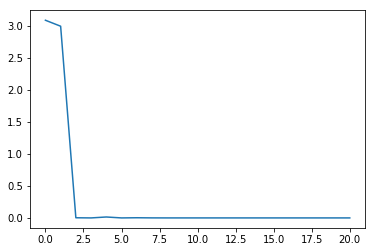

In [12]:
 _ = plt.plot(backfit.output_model_variation['e2'])

In [19]:
backfit.output_model_dict['e2'].lr.coef_

array([-0.929])

In [13]:
for values in backfit.output_model_dict.values():
    print(values.coef_())
    print(values.get_feature_names())

[-0.929]
['x2^0x4^0']
[0.021 -0.087 -0.057 0.006 0.020 0.980 -0.073 -0.027 -0.062 -0.004 0.021 -0.022 -0.019 -0.001 0.476 -0.010 0.004 -0.025 0.004 -0.002]
['1', 'x1^0', 'x2^0', 'x2^2', 'x3^0', 'x1^2', 'x1^0x2^0', 'x1^0x3^0', 'x2^0x3^0', 'x3^2', 'x1^3', 'x1^2x2^0', 'x1^2x3^0', 'x1^0x2^2', 'x1^0x2^0x3^0', 'x1^0x3^2', 'x2^3', 'x2^2x3^0', 'x2^0x3^2', 'x3^3']
[0.018]
['x1^0x5^0']
[-0.486]
['x3^0x4^0']
